# COVID-19 Prediction Project

# Name:       Youssef Samy Youssef
# Major:      Communication Engineer
# Instructor: Dr El-Hossiny
# Course:     ETA_AI_Benha
# Group:      09


# Dataset:    COVID-19
# Link:       https://www.kaggle.com/datasets/tr1gg3rtrash/balanced-augmented-covid-cxr-dataset

# Libraries Import

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL.ImImagePlugin import split
from pandas.core.common import random_state

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (Dense, Dropout, Flatten,
                                     Conv2D, MaxPooling2D, InputLayer, AveragePooling2D, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import models


# Dataset Import

In [2]:
data_path = 'data'

In [3]:
x_data = []
y_data = []

In [4]:
for class_name in os.listdir(data_path):
    for img_name in os.listdir(os.path.join(data_path, class_name)):
        im = cv2.imread(os.path.join(data_path, class_name, img_name))
        x_data.append(im)
        y_data.append(class_name.upper())

In [5]:
x_data = np.array(x_data)
y_data = np.array(y_data)

# Data Exploration

In [6]:
print('x size:', x_data.shape)
print('y size:', y_data.shape)

x size: (16959, 224, 224, 3)
y size: (16959,)


In [7]:
classes_str = list(set(y_data.tolist()))

print('Classes:', classes_str)

Classes: ['COVID', 'NORMAL']


In [8]:
for class_name in classes_str:
    print(f"#{class_name} samples in train data:", x_data[y_data == class_name].shape[0])
    print('')

#COVID samples in train data: 8745

#NORMAL samples in train data: 8214



# Image Presentation

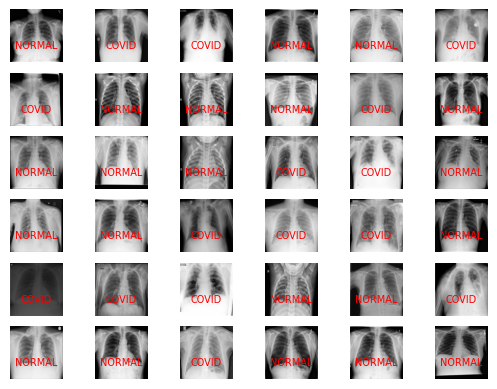

In [9]:
counts_to_draw = 36
counts_per_row = 6

for im_number, im_index in enumerate(np.random.randint(0, x_data.shape[0], counts_to_draw)):
    plt.subplot(counts_to_draw // counts_per_row, counts_per_row, im_number + 1)
    plt.imshow(x_data[im_index])
    plt.title(y_data[im_index],
              y=0.1,
              color='red',
              fontdict={'fontsize': 7})
    plt.axis('off')

plt.show()

# Image Augmentation

In [10]:
def augment_flip(image):
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)

    return image

In [11]:
def augment_rotate(image):
    angle = np.random.randint(-30, 31)
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, M, (width, height))
    return image

In [12]:
def augment_shift(image):
    height, width = image.shape[:2]
    tx = 0.1 * np.sin(np.random.randint(0, 2 * np.pi)) * width
    ty = 0.1 * np.sin(np.random.randint(0, 2 * np.pi)) * height
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, (width, height))
    return image

In [13]:
# _x_data_aug = []
# _y_data_aug = []
# 
# for label, img in zip(y_data, x_data):
#     for j in range(2):
#         _temp = augment_flip(img)
#         _temp = augment_rotate(_temp)
#         _temp = augment_shift(_temp)
#         _x_data_aug.append(_temp)
#         _y_data_aug.append(label)
# 
# _x_data_aug = np.array(_x_data_aug)
# _y_data_aug = np.array(_y_data_aug)

In [14]:
# print('augmented x size:', _x_data_aug.shape)
# print('augmented y size:', _y_data_aug.shape)

In [15]:
# counts_to_draw = 20
# counts_per_row = 5
# 
# for im_number, im_index in enumerate(np.random.randint(0, len(_x_data_aug), counts_to_draw)):
#     plt.subplot(counts_to_draw // counts_per_row, counts_per_row, im_number + 1)
#     plt.imshow(_x_data_aug[im_index])
#     plt.title(_y_data_aug[im_index],
#               y=0.1,
#               color='red',
#               fontdict={'fontsize': 8})
#     plt.axis('off')
# 
# plt.show()

In [16]:
# x_data = np.concatenate((x_data, _x_data_aug), axis=0)
# y_data = np.concatenate((y_data, _y_data_aug), axis=0)

# Data Preparation for training

In [17]:
label_encoder = LabelEncoder().fit(y_data)
y_data_encoded = np.array(label_encoder.transform(y_data))

In [18]:
print("Test Samples: ", y_data[:5])

Test Samples:  ['COVID' 'COVID' 'COVID' 'COVID' 'COVID']


In [19]:
print("Test Samples: ", y_data_encoded[:5])

Test Samples:  [0 0 0 0 0]


In [20]:
y_data_encoded = to_categorical(y_data_encoded)

In [21]:
print("Test Samples: ", y_data_encoded[:5])

Test Samples:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [22]:
x_data[0].shape

(224, 224, 3)

In [27]:
x_data = x_data / 255.0

In [28]:
print(set(x_data[0].flatten()))

{0.18823529411764706, 0.06274509803921569, 0.49411764705882355, 0.1843137254901961, 0.37254901960784315, 0.3176470588235294, 0.3764705882352941, 0.4392156862745098, 0.44313725490196076, 0.3058823529411765, 1.0, 0.06666666666666667, 0.12549019607843137, 0.15294117647058825, 0.21568627450980393, 0.00784313725490196, 0.07058823529411765, 0.13333333333333333, 0.19607843137254902, 0.19215686274509805, 0.12941176470588237, 0.25098039215686274, 0.28627450980392155, 0.2784313725490196, 0.3137254901960784, 0.3411764705882353, 0.011764705882352941, 0.07450980392156863, 0.3686274509803922, 0.403921568627451, 0.43137254901960786, 0.2, 0.13725490196078433, 0.01568627450980392, 0.2627450980392157, 0.39215686274509803, 0.20392156862745098, 0.3215686274509804, 0.32941176470588235, 0.3333333333333333, 0.3843137254901961, 0.5098039215686274, 0.5215686274509804, 0.5294117647058824, 0.5372549019607843, 0.5450980392156862, 0.5019607843137255, 0.5490196078431373, 0.5568627450980392, 0.5647058823529412, 0.57

In [29]:
print(x_data.shape)

(16959, 224, 224, 3)


In [30]:
x_train, x_test, y_train_encoded, y_test_encoded = train_test_split(x_data, y_data_encoded,
                                                                    random_state=19, test_size=0.3, shuffle=True)

In [31]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train_encoded.shape)
print("y_test shape:", y_test_encoded.shape)

x_train shape: (11871, 224, 224, 3)
x_test shape: (5088, 224, 224, 3)
y_train shape: (11871, 2)
y_test shape: (5088, 2)


# CNN-Model Architecture

In [32]:
cnn_model = Sequential()

cnn_model.add(InputLayer(shape=x_data.shape[1:]))

cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

cnn_model.add(Conv2D(16, (3, 3), padding='same'))
cnn_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# cnn_model.add(Conv2D(1, (3, 3), padding='same'))
# cnn_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

cnn_model.add(Flatten())

# cnn_model.add(Dense(256 activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
# cnn_model.add(Dense(64, activation='relu'))
# cnn_model.add(Dense(32, activation='relu'))
# cnn_model.add(Dense(8, activation='relu'))
# cnn_model.add(Dense(4, activation='relu'))
# cnn_model.add(Dense(2, activation='relu'))
cnn_model.add(Dense(len(classes_str), activation='softmax'))

In [33]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 112, 112, 64)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 56, 56, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 28, 28, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,801,682 (6.87 MB)

 Trainable params: 1,801,682 (6.87 MB)

 Non-trainable params: 0 (0.00 B)

# Early Stopping & Reduce Learning Rate

In [34]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

learning_rate_reduction = (
    ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=2,
        verbose=200,
        factor=0.5,
        min_lr=0.00001))


# Model Compilation & Training

In [35]:
checkpoint = ModelCheckpoint(
    'best_model_1.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
)

In [36]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
if os.path.isfile('best_model_1.keras'):
    cnn_model = models.load_model('best_model_1.keras')

In [37]:
history = cnn_model.fit(
    x_train, y_train_encoded,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_split=0.2,
    callbacks=[learning_rate_reduction, early_stopping, checkpoint]
)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1452s 19s/step - accuracy: 0.5128 - loss: 3.0512 - val_accuracy: 0.5002 - val_loss: 0.6784 - learning_rate: 0.0010
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1574s 21s/step - accuracy: 0.6422 - loss: 0.6343 - val_accuracy: 0.7259 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1501s 20s/step - accuracy: 0.7054 - loss: 0.5548 - val_accuracy: 0.7356 - val_loss: 0.5062 - learning_rate: 0.0010
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1530s 20s/step - accuracy: 0.7252 - loss: 0.5214 - val_accuracy: 0.7482 - val_loss: 0.4886 - learning_rate: 0.0010
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1539s 20s/step - accuracy: 0.7428 - loss: 0.5004 - val_accuracy: 0.7617 - val_loss: 0.4835 - learning_rate: 0.0010


# Training History

In [38]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


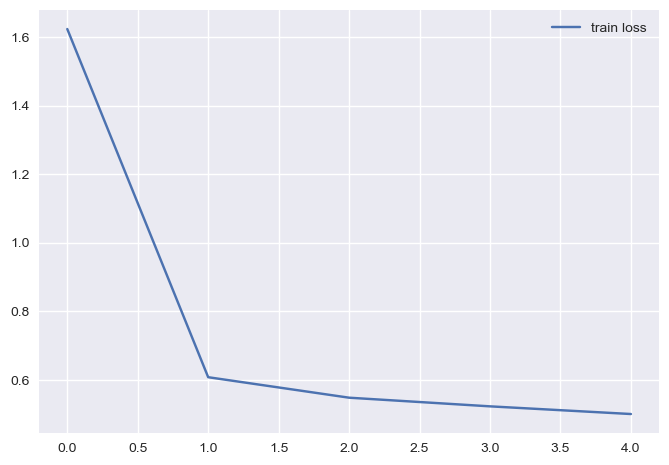

In [39]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['loss'], label='train loss')

plt.legend()
plt.show()

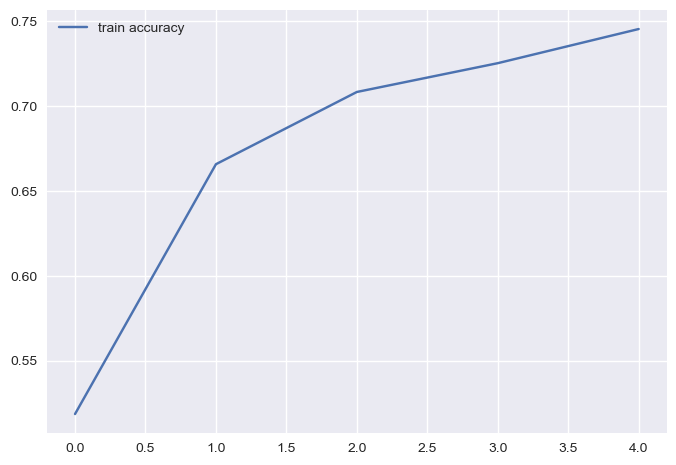

In [40]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['accuracy'], label='train accuracy')

plt.legend()
plt.show()

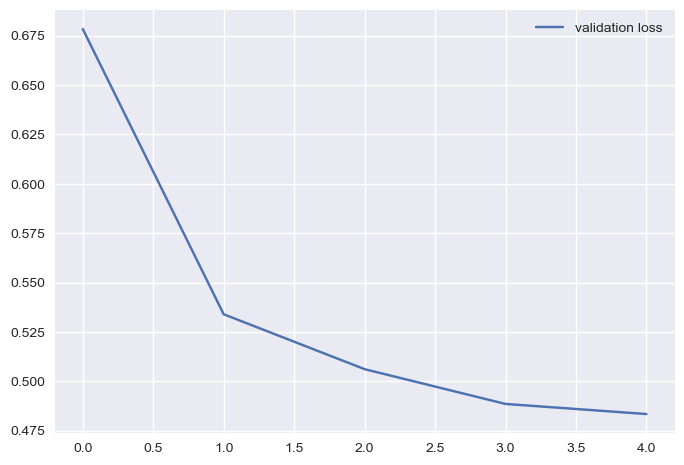

In [41]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['val_loss'], label='validation loss')

plt.legend()
plt.show()

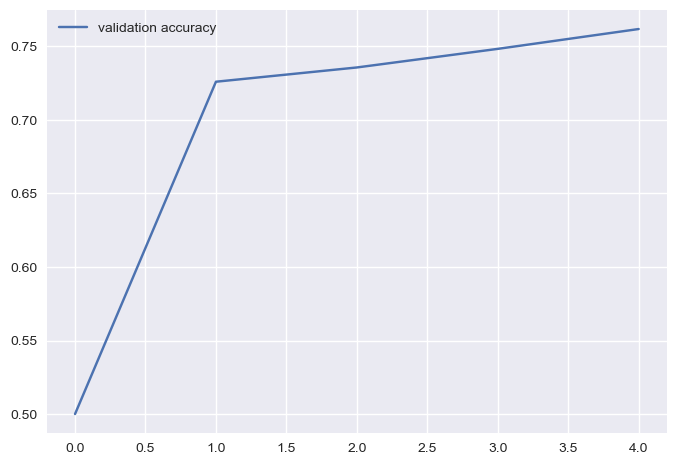

In [42]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.legend()
plt.show()


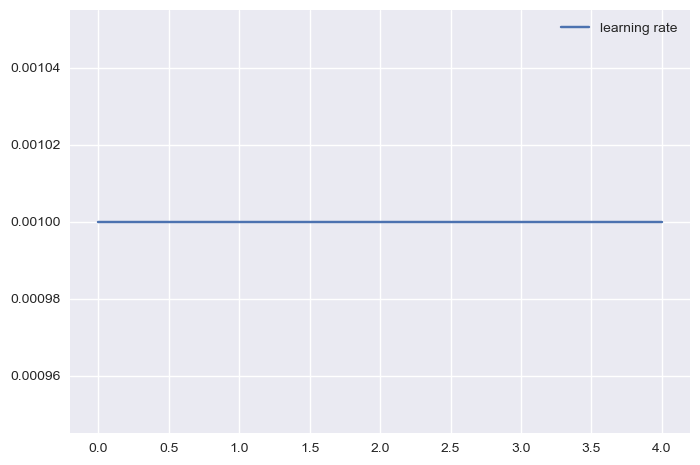

In [43]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['learning_rate'], label='learning rate')

plt.legend()
plt.show()

# Model Evaluation

In [44]:
y_predict_encoded = cnn_model.predict(x_test)

159/159 ━━━━━━━━━━━━━━━━━━━━ 114s 710ms/step


In [45]:
_y_predict_ = [list(i).index(max(i)) for i in y_predict_encoded]
_y_test_ = [list(i).index(max(i)) for i in y_test_encoded]

print("Accuracy", metrics.accuracy_score(_y_test_, _y_predict_))

Accuracy 0.7594339622641509


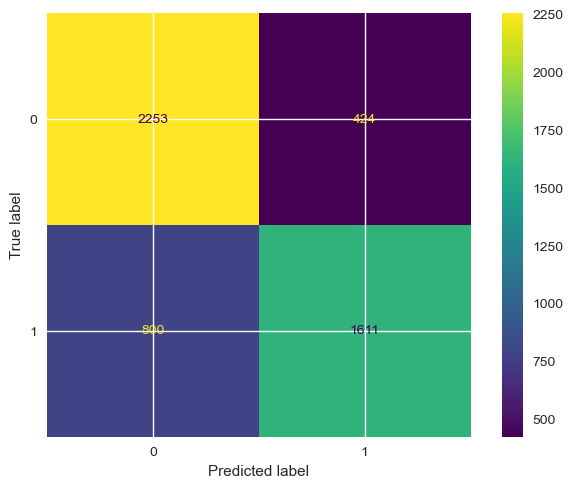

In [46]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(_y_test_, _y_predict_)
).plot()

# Model Deployment

In [47]:
# cnn_model.save('model.h5')
import pickle

labels = {idx: label for idx, label in enumerate(label_encoder.classes_)}

pickle.dump(cnn_model, open('model_1.pkl', 'wb'))
pickle.dump(labels, open('model_1_labels.pkl', 'wb'))
print(labels)

{0: 'COVID', 1: 'NORMAL'}


# Pretrained model VGG16

In [48]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(len(classes_str), activation='softmax')(x)

vgg16_model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False


In [49]:
vgg16_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,242,050 (58.14 MB)

 Trainable params: 527,362 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [50]:
vgg16_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [51]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

learning_rate_reduction = (
    ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=2,
        verbose=200,
        factor=0.5,
        min_lr=0.00001))

checkpoint = ModelCheckpoint(
    'best_model_2.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
)


In [ ]:
if os.path.isfile('best_model_2.keras'):
    vgg16_model = models.load_model('best_model_2.keras')

In [52]:
history = vgg16_model.fit(
    x_train, y_train_encoded,
    epochs=5,
    verbose=1,
    callbacks=[early_stopping, learning_rate_reduction, checkpoint],
    validation_split=0.2
)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 881s 3s/step - accuracy: 0.7740 - loss: 0.4789 - val_accuracy: 0.8796 - val_loss: 0.2949 - learning_rate: 0.0010
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 868s 3s/step - accuracy: 0.8814 - loss: 0.2862 - val_accuracy: 0.9006 - val_loss: 0.2362 - learning_rate: 0.0010
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 847s 3s/step - accuracy: 0.9026 - loss: 0.2431 - val_accuracy: 0.8867 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 854s 3s/step - accuracy: 0.9116 - loss: 0.2119 - val_accuracy: 0.9234 - val_loss: 0.1863 - learning_rate: 0.0010
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 847s 3s/step - accuracy: 0.9247 - loss: 0.1923 - val_accuracy: 0.9314 - val_loss: 0.1737 - learning_rate: 0.0010


In [53]:
y_predict_encoded = vgg16_model.predict(x_test)

_y_predict_ = [list(i).index(max(i)) for i in y_predict_encoded]
_y_test_ = [list(i).index(max(i)) for i in y_test_encoded]

print("Accuracy", metrics.accuracy_score(_y_test_, _y_predict_))

159/159 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step
Accuracy 0.9367138364779874


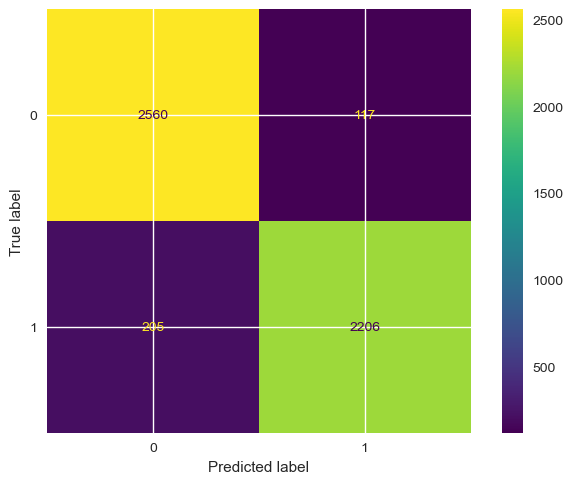

In [54]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(_y_test_, _y_predict_)
).plot() 

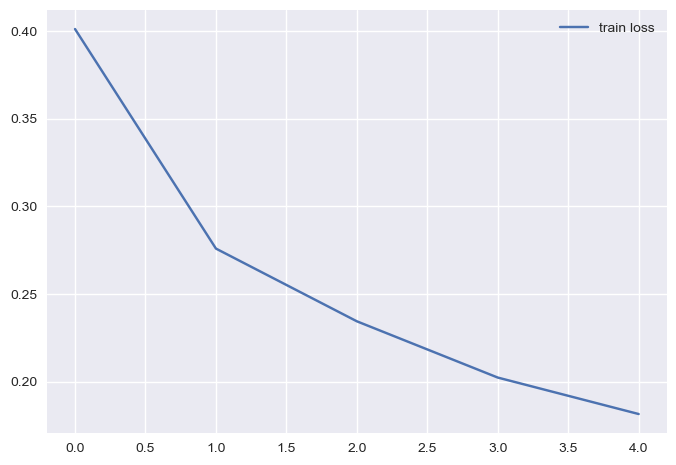

In [55]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['loss'], label='train loss')

plt.legend()
plt.show()

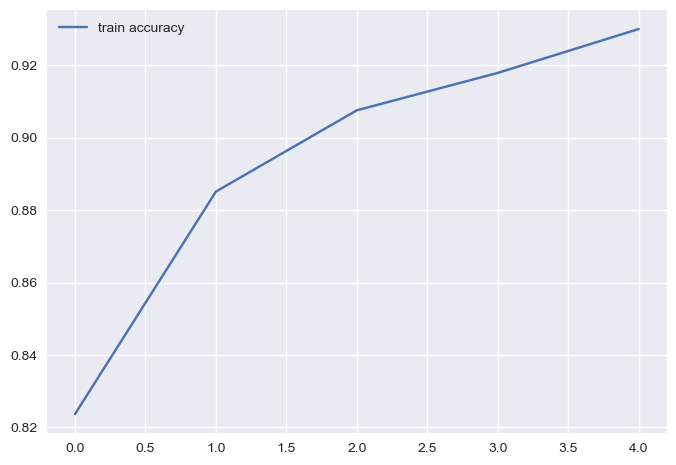

In [56]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['accuracy'], label='train accuracy')

plt.legend()
plt.show()

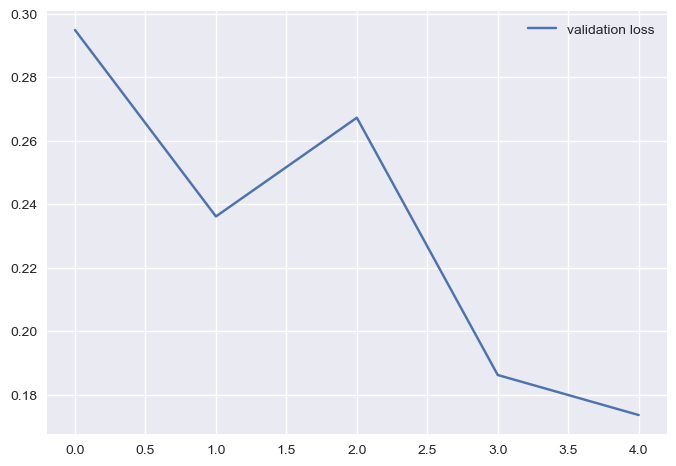

In [57]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['val_loss'], label='validation loss')

plt.legend()
plt.show()

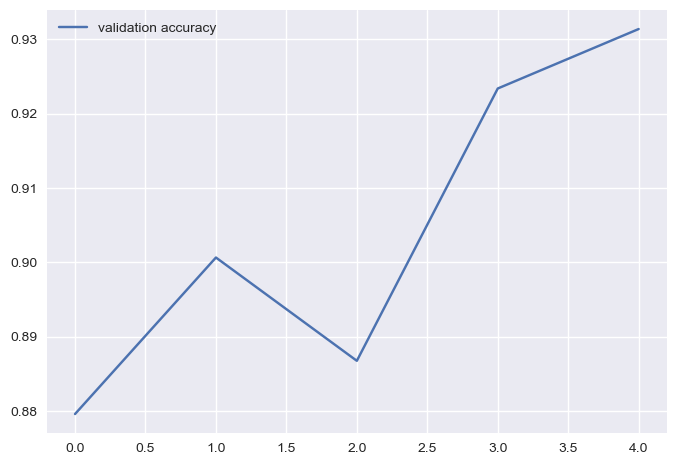

In [58]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.legend()
plt.show()

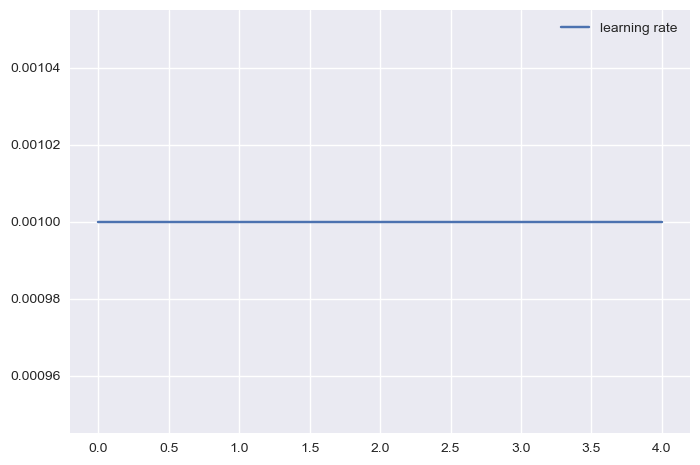

In [59]:
plt.style.use(plt.style.available[11])

plt.plot(history.history['learning_rate'], label='learning rate')

plt.legend()
plt.show()

# VGG Deployment

In [60]:
# pickle.dump(vgg16_model, open('model_2.pkl', 'wb'))